In [328]:
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy

import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as random
from tqdm import tqdm

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_feasible, init_to_median, init_to_sample, \
    init_to_uniform, init_to_value

from pymc3.gp.util import plot_gp_dist

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

In [227]:
# Don't sting my eyes
%config InlineBackend.figure_format = 'retina'
sns.set()

In [228]:
numpyro.enable_x64()

In [229]:
N=30 
sigma_obs=0.15
N_test=400
np.random.seed(0)
X = jnp.linspace(-1, 1, N)
Y = X + 0.2 * jnp.power(X, 3.0) + 0.5 * jnp.power(0.5 + X, 2.0) * jnp.sin(4.0 * X)
Y += sigma_obs * np.random.randn(N)
Y -= jnp.mean(Y)
Y /= jnp.std(Y)

assert X.shape == (N,)
assert Y.shape == (N,)

X_test = jnp.linspace(-1.3, 1.3, N_test)

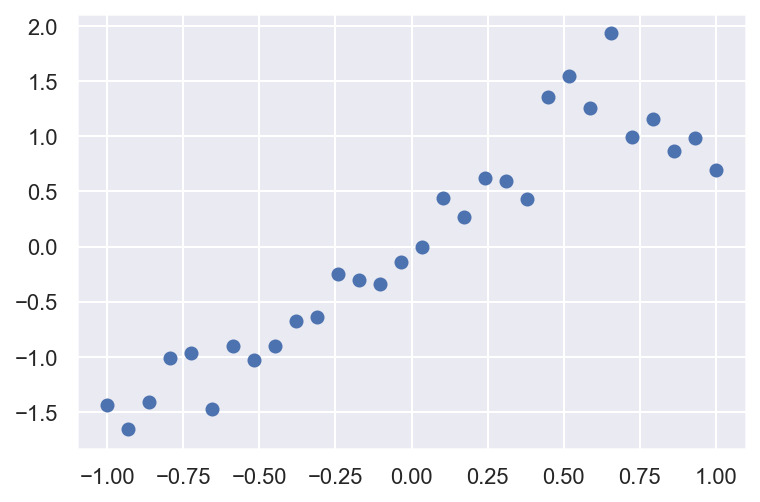

In [230]:
plt.scatter(X, Y);

In [231]:
# squared exponential kernel with diagonal noise term
def kernel(X, Z, var, length, noise, jitter=1.0e-6, include_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    if include_noise:
        k += (noise + jitter) * jnp.eye(X.shape[0])
    return k


def model(X, Y):
    # set uninformative log-normal priors on our three kernel hyperparameters
    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 10.0))
    noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, 10.0))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 10.0))

    # compute kernel
    k = kernel(X, X, var, length, noise)

    # sample Y according to the standard gaussian process formula
    numpyro.sample("Y", dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k),
                   obs=Y)


# helper function for doing hmc inference
def run_inference(rng_key, model, X, Y, init_strategy="median", num_warmup=1000, num_samples=1000, 
                  thinning=2, num_chains=1):
    start = time.time()
    # demonstrate how to use different HMC initialization strategies
    if init_strategy == "value":
        init_strategy = init_to_value(values={"kernel_var": 1.0, "kernel_noise": 0.05, "kernel_length": 0.5})
    elif init_strategy == "median":
        init_strategy = init_to_median(num_samples=10)
    elif init_strategy == "feasible":
        init_strategy = init_to_feasible()
    elif init_strategy == "sample":
        init_strategy = init_to_sample()
    elif init_strategy == "uniform":
        init_strategy = init_to_uniform(radius=1)
    kernel = NUTS(model, init_strategy=init_strategy)
    mcmc = MCMC(kernel, num_warmup, num_samples, num_chains=num_chains, thinning=thinning,
                progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True)
    mcmc.run(rng_key, X, Y)
    mcmc.print_summary()
    print('\nMCMC elapsed time:', time.time() - start)
    return mcmc.get_samples()


# do GP prediction for a given set of hyperparameters. this makes use of the well-known
# formula for gaussian process predictions
def predict(rng_key, X, Y, X_test, var, length, noise):
    # compute kernels between train and test data, etc.
    k_pp = kernel(X_test, X_test, var, length, noise, include_noise=True)
    k_pX = kernel(X_test, X, var, length, noise, include_noise=False)
    k_XX = kernel(X, X, var, length, noise, include_noise=True)
    K_xx_inv = jnp.linalg.inv(k_XX)
    K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
    sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.)) * jax.random.normal(rng_key, X_test.shape[:1])
    mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, Y))
    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    return mean, mean + sigma_noise

In [232]:
# do inference
rng_key, rng_key_predict = random.split(random.PRNGKey(0))
samples = run_inference(rng_key, model, X, Y, num_chains=1)

sample: 100%|██████████| 2000/2000 [00:04<00:00, 427.28it/s, 7 steps of size 5.72e-01. acc. prob=0.90]  


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length      0.65      0.41      0.58      0.27      0.95    184.66      1.00
   kernel_noise      0.07      0.02      0.07      0.04      0.11    450.11      1.00
     kernel_var      3.33     10.52      1.38      0.18      5.62    280.95      1.00

Number of divergences: 0

MCMC elapsed time: 4.897175073623657


In [233]:
# do prediction
vmap_args = (random.split(rng_key_predict, samples['kernel_var'].shape[0]),
             samples['kernel_var'], samples['kernel_length'], samples['kernel_noise'])
means, predictions = vmap(lambda rng_key, var, length, noise:
                          predict(rng_key, X, Y, X_test, var, length, noise))(*vmap_args)

mean_prediction = np.mean(means, axis=0)
percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)

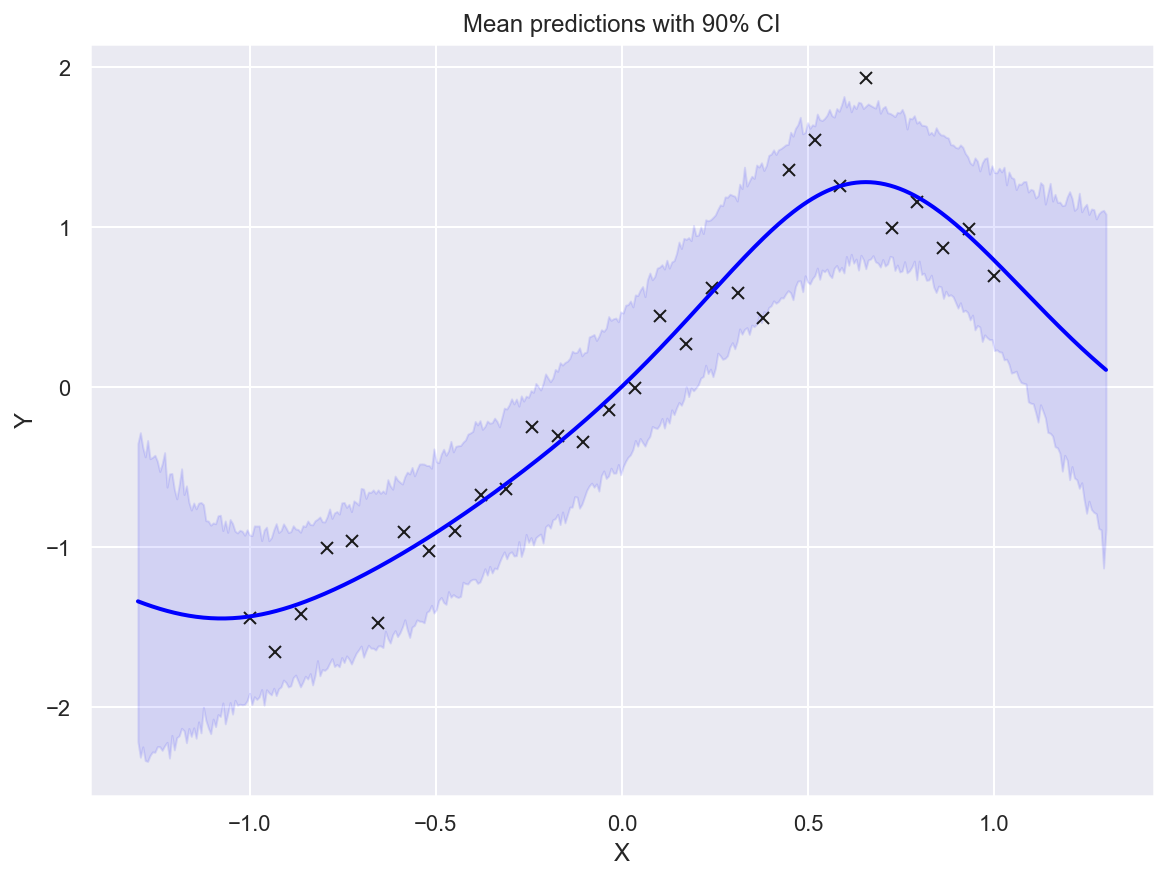

In [234]:
# make plots
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

# plot training data
ax.plot(X, Y, 'kx')
# plot 90% confidence level of predictions
ax.fill_between(X_test, percentiles[0, :], percentiles[1, :], color='blue', alpha=0.1)
# plot mean prediction
ax.plot(X_test, mean_prediction, 'blue', ls='solid', lw=2.0)
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI");

# Classification

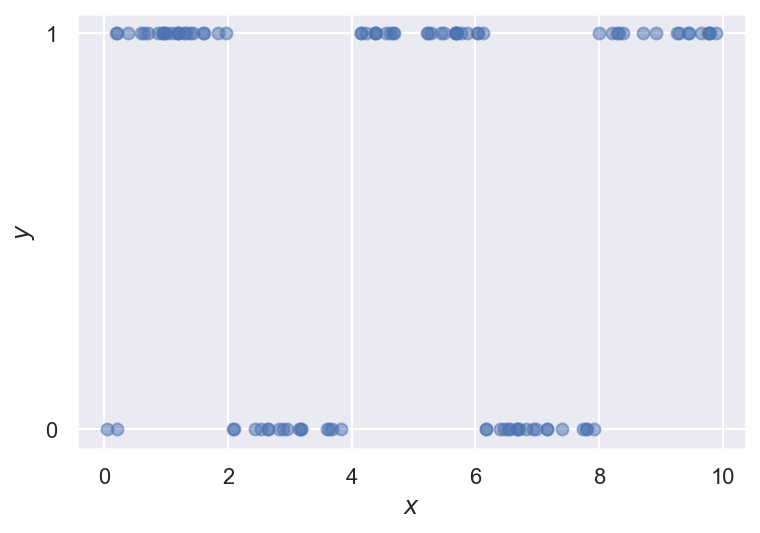

In [335]:
np.random.seed(0)

def true_f(x):
    return jnp.sin(x * jnp.pi * 0.5) * 10

n = 100
x = jnp.array(np.sort(np.random.uniform(0, 10, n)))
f = true_f(x)
y = jnp.array(scipy.stats.bernoulli.rvs(jax.scipy.special.expit(f)))

plt.scatter(x, y, alpha=0.5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.yticks([0, 1]);

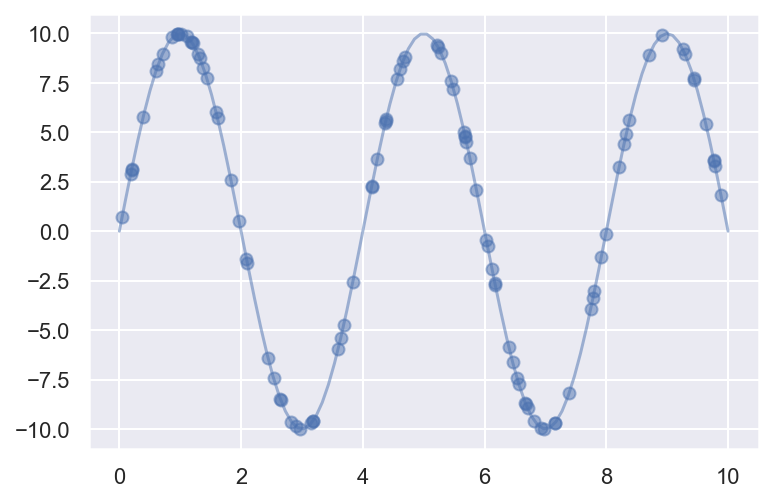

In [336]:
fig, ax = plt.subplots()
x_plot = np.linspace(0, 10, 100)
ax.plot(x_plot, true_f(x_plot), alpha=0.5)
ax.scatter(x, f, alpha=0.5)

In [276]:
def kernel(X, Xs, var, length):
    deltaX = jnp.power((X[:, None] - Xs) / length, 2.0)
    k = var * jnp.exp(-0.5 * deltaX)
    return k


def compute_f(var, length, eta, mu, X, jitter=1.0e-6):
    N = X.shape[0]
    K = kernel(X, X, var, length) + jitter * jnp.eye(N)
    L = jnp.linalg.cholesky(K)
    return jnp.matmul(L, eta) + mu


def model(X, y):
    
    N = y.shape[0]
    
    # set uninformative log-normal priors on our three kernel hyperparameters
    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 10.0))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 10.0))
    
    # beta = numpyro.sample('beta', dist.Normal(np.zeros(N), 1))
    eta = numpyro.sample('eta', dist.Normal(np.zeros(N), 1))
    
    mu = jnp.zeros(N)
    f = compute_f(var=var, length=length, mu=mu, eta=eta, X=X)
    
    # mu = jnp.zeros(X.shape[0])
    numpyro.sample("obs", dist.Bernoulli(logits=f), obs=y)

In [277]:
# Set random seed for reproducibility.
rng_key = random.PRNGKey(0)

nuts = MCMC(NUTS(model, target_accept_prob=0.8, max_tree_depth=10),
            num_samples=500, num_warmup=500)
nuts.run(rng_key, x, y)

sample: 100%|██████████| 1000/1000 [01:17<00:00, 12.92it/s, 127 steps of size 2.56e-02. acc. prob=0.81]


In [278]:
np.array(kernel(x, x, var=1, length=0.8))

array([[1.00000000e+00, 9.84600278e-01, 9.81613944e-01, ...,
        8.70670058e-33, 6.56487803e-33, 1.47661433e-33],
       [9.84600278e-01, 1.00000000e+00, 9.99864349e-01, ...,
        7.29149263e-32, 5.52033976e-32, 1.26863467e-32],
       [9.81613944e-01, 9.99864349e-01, 1.00000000e+00, ...,
        8.88013510e-32, 6.72566166e-32, 1.54873860e-32],
       ...,
       [8.70670058e-33, 7.29149263e-32, 8.88013510e-32, ...,
        1.00000000e+00, 9.99730553e-01, 9.89519683e-01],
       [6.56487803e-33, 5.52033976e-32, 6.72566166e-32, ...,
        9.99730553e-01, 1.00000000e+00, 9.92592440e-01],
       [1.47661433e-33, 1.26863467e-32, 1.54873860e-32, ...,
        9.89519683e-01, 9.92592440e-01, 1.00000000e+00]])

In [279]:
RBF(0.8)(np.array(x.reshape(-1, 1)))

array([[1.00000000e+00, 9.84600278e-01, 9.81613944e-01, ...,
        8.70670058e-33, 6.56487803e-33, 1.47661433e-33],
       [9.84600278e-01, 1.00000000e+00, 9.99864349e-01, ...,
        7.29149263e-32, 5.52033976e-32, 1.26863467e-32],
       [9.81613944e-01, 9.99864349e-01, 1.00000000e+00, ...,
        8.88013510e-32, 6.72566166e-32, 1.54873860e-32],
       ...,
       [8.70670058e-33, 7.29149263e-32, 8.88013510e-32, ...,
        1.00000000e+00, 9.99730553e-01, 9.89519683e-01],
       [6.56487803e-33, 5.52033976e-32, 6.72566166e-32, ...,
        9.99730553e-01, 1.00000000e+00, 9.92592440e-01],
       [1.47661433e-33, 1.26863467e-32, 1.54873860e-32, ...,
        9.89519683e-01, 9.92592440e-01, 1.00000000e+00]])

In [282]:
def gp_predict(X, Xnew, samples, i, eps=1.0e-6):
    f = compute_f(var=samples['kernel_var'][i],
                  length=samples['kernel_length'][i],
                  eta=samples['eta'][i], 
                  mu=jnp.zeros(X.shape[0]), X=X)
    kernel = samples['kernel_var'][i]**2 * RBF(samples['kernel_length'][i]) 
    kernel += eps * WhiteKernel()
    gpr = GaussianProcessRegressor(kernel=kernel, optimizer=None, random_state=0)
    gpr.fit(X.reshape(-1, 1), f)
    f_predict = gpr.predict(Xnew.reshape(-1, 1))
    p_predict = scipy.special.expit(f_predict)
    return f_predict, p_predict


In [283]:
nuts_samples = nuts.get_samples()

n_samples = nuts_samples['kernel_var'].shape[0]
f_predict = np.zeros((n_samples, x.shape[0]))
p_predict = np.zeros((n_samples, x.shape[0]))
for i in tqdm(range(n_samples)):
    f_predict[i], p_predict[i] = gp_predict(X=x, Xnew=x, samples=nuts_samples, i=i)

100%|██████████| 500/500 [00:08<00:00, 61.02it/s]


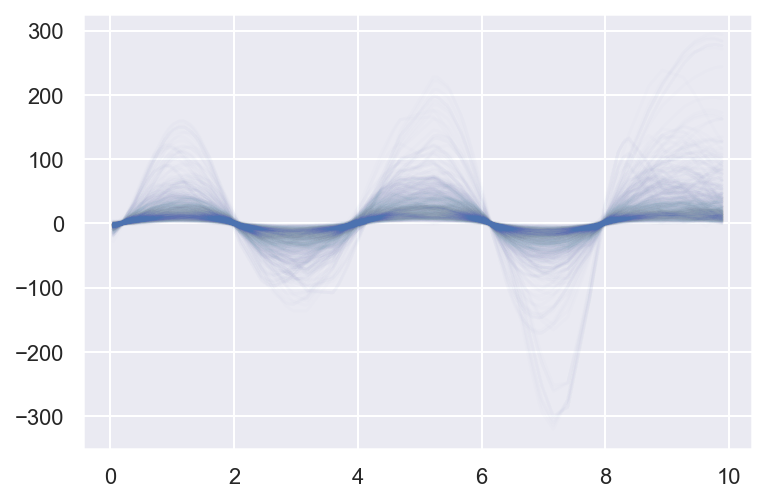

In [284]:
fig, ax = plt.subplots()
for i in range(n_samples):
    ax.plot(x, f_predict[i], color='C0', alpha=0.01)

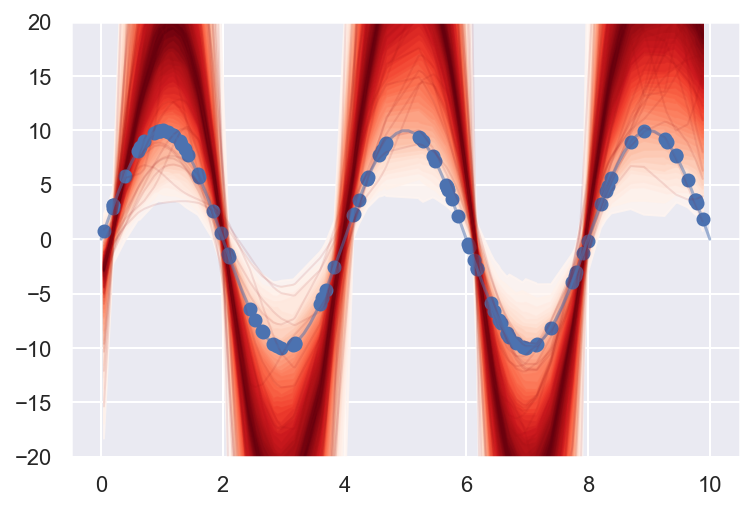

In [285]:
fig, ax = plt.subplots()
plot_gp_dist(ax, f_predict, x)
ax.scatter(x, f)
x_plot = np.linspace(0, 10, 100)
ax.plot(x_plot, true_f(x_plot), alpha=0.5)
ax.set_ylim(-20, 20);

# other way to predict

In [337]:
def gp_predict(X, samples, i, Xnew=None, jitter=1.0e-6):
    
    var=samples['kernel_var'][i]
    length=samples['kernel_length'][i]
    eta=samples['eta'][i] 
    mu=jnp.zeros(X.shape[0])
    
    N = X.shape[0]
    K = kernel(X, X, var, length) + jitter*jnp.eye(N)
    L = jnp.linalg.cholesky(K)
    f = jnp.matmul(L, eta) + mu
    
    if Xnew is not None:
        M = Xnew.shape[0]
        k_pp = kernel(Xnew, Xnew, var, length) + jitter*jnp.eye(M)
        k_pX = kernel(Xnew, X, var, length)
        k_XX = kernel(X, X, var, length) + jitter*jnp.eye(N)
        K_xx_inv = jnp.linalg.inv(k_XX)
        K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
        # sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.)) * jax.random.normal(rng_key, X_test.shape[:1])
        f_predict = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, f))
    else:
        f_predict = f
    
    p_predict = scipy.special.expit(f_predict)
    return f_predict, p_predict


In [307]:
n_samples = nuts_samples['kernel_var'].shape[0]
f_predict = np.zeros((n_samples, x.shape[0]))
p_predict = np.zeros((n_samples, x.shape[0]))
for i in tqdm(range(n_samples)):
    f_predict[i], p_predict[i] = gp_predict(X=x, Xnew=None, samples=nuts_samples, i=i)

100%|██████████| 500/500 [00:08<00:00, 56.13it/s]


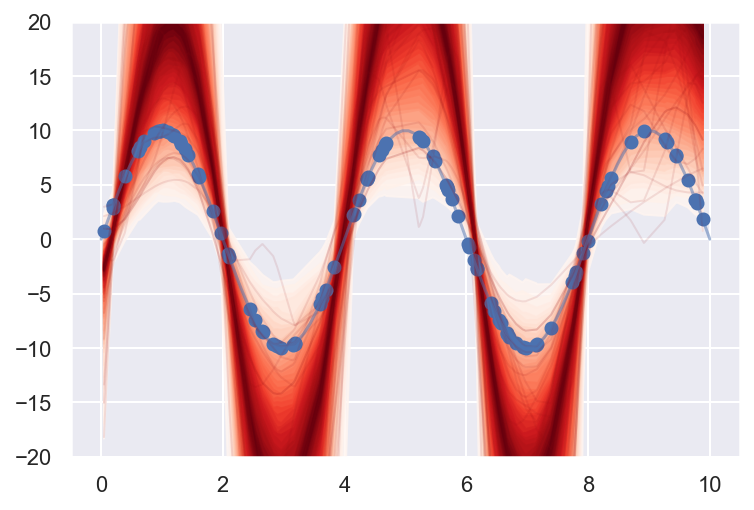

In [308]:
fig, ax = plt.subplots()
plot_gp_dist(ax, f_predict, x)
ax.scatter(x, f)
x_plot = np.linspace(0, 10, 100)
ax.plot(x_plot, true_f(x_plot), alpha=0.5)
ax.set_ylim(-20, 20);

# Sparse?

In [338]:
def kernel(X, Xs, var, length):
    deltaX = jnp.power((X[:, None] - Xs) / length, 2.0)
    k = var * jnp.exp(-0.5 * deltaX)
    return k


def sparse_model(X, y, M=25, jitter=1e-06):
    
    N = X.shape[0]
    
    # set uninformative log-normal priors on our three kernel hyperparameters
    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 10.0))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 10.0))
    
    # beta = numpyro.sample('beta', dist.Normal(np.zeros(N), 1))
    eta = numpyro.sample('eta', dist.Normal(np.zeros(M), 1))
    
    with numpyro.plate("XmPlate", M):
        Xm = numpyro.sample("Xm", dist.Uniform(low=0, high=10))
        
        
    mu_m = jnp.zeros(M)
    
    Km = kernel(Xm, Xm, var, length) + jitter*jnp.eye(M)
    Lm = jnp.linalg.cholesky(Km)
    fm = jnp.matmul(Lm, eta) + mu_m
    
    k_pp = kernel(X, X, var, length) + jitter*jnp.eye(N)
    k_pX = kernel(X, Xm, var, length)
    k_XX = Km #kernel(Xm, Xm, var, length) + jitter*jnp.eye(N)
    K_xx_inv = jnp.linalg.inv(k_XX)
    K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
    # sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.)) * jax.random.normal(rng_key, X_test.shape[:1])
    f_predict = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, fm))

    # mu = jnp.zeros(X.shape[0])
    numpyro.sample("obs", dist.Bernoulli(logits=f_predict), obs=y)

In [339]:
# Set random seed for reproducibility.
rng_key = random.PRNGKey(0)

nuts = MCMC(NUTS(sparse_model, target_accept_prob=0.8, max_tree_depth=10),
            num_samples=500, num_warmup=500)
nuts.run(rng_key, x, y, M=25)

sample: 100%|██████████| 1000/1000 [01:31<00:00, 10.98it/s, 1023 steps of size 5.05e-04. acc. prob=0.84]


In [340]:
def gp_predict_sparse(Xnew, samples, i, jitter=1.0e-6):
    
    var=samples['kernel_var'][i]
    length=samples['kernel_length'][i]
    eta=samples['eta'][i] 
    X=samples['Xm'][i]
    mu=jnp.zeros(X.shape[0])
    
    N = X.shape[0]
    K = kernel(X, X, var, length) + jitter*jnp.eye(N)
    L = jnp.linalg.cholesky(K)
    f = jnp.matmul(L, eta) + mu
    
    if Xnew is not None:
        M = Xnew.shape[0]
        k_pp = kernel(Xnew, Xnew, var, length) + jitter*jnp.eye(M)
        k_pX = kernel(Xnew, X, var, length)
        k_XX = kernel(X, X, var, length) + jitter*jnp.eye(N)
        K_xx_inv = jnp.linalg.inv(k_XX)
        K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
        # sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.)) * jax.random.normal(rng_key, X_test.shape[:1])
        f_predict = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, f))
    else:
        f_predict = f
    
    p_predict = scipy.special.expit(f_predict)
    return f_predict, p_predict

In [341]:
nuts_samples = nuts.get_samples()

n_samples = nuts_samples['kernel_var'].shape[0]
f_predict = np.zeros((n_samples, x.shape[0]))
p_predict = np.zeros((n_samples, x.shape[0]))
for i in tqdm(range(n_samples)):
    f_predict[i], p_predict[i] = gp_predict_sparse(Xnew=x, samples=nuts_samples, i=i)

100%|██████████| 500/500 [00:09<00:00, 53.57it/s]


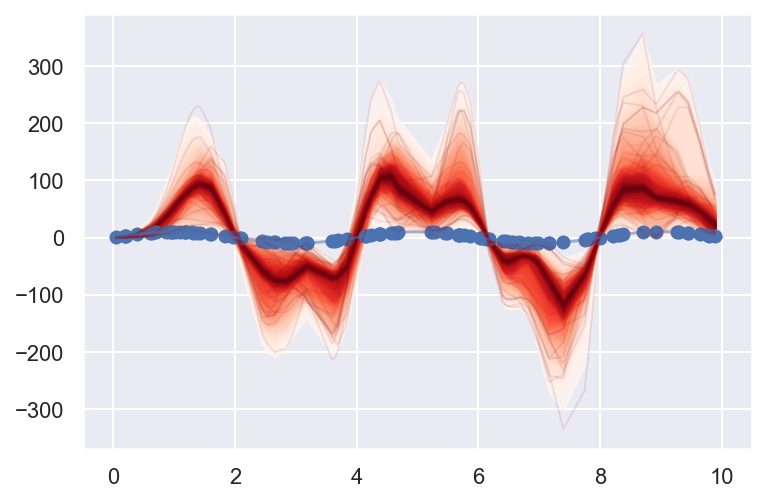

In [343]:
fig, ax = plt.subplots()
plot_gp_dist(ax, f_predict, x)
ax.scatter(x, f)
x_plot = np.linspace(0, 10, 100)
ax.plot(x_plot, true_f(x_plot), alpha=0.5)
# ax.set_ylim(-20, 20);

# With more data

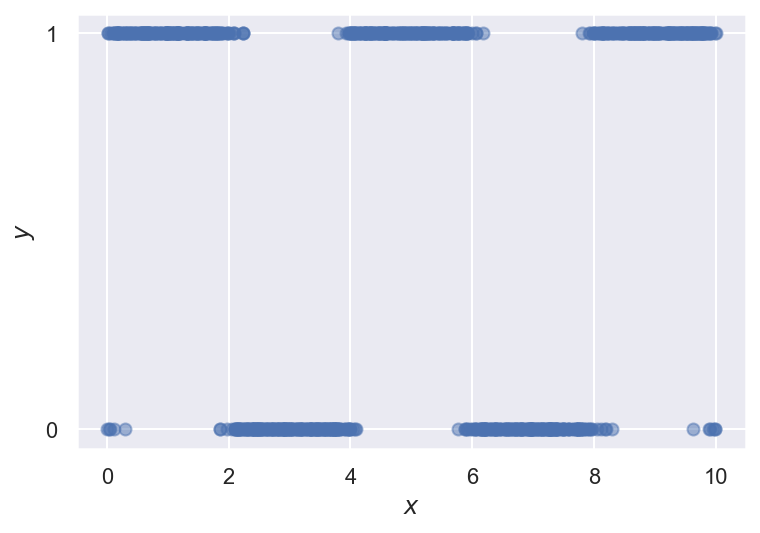

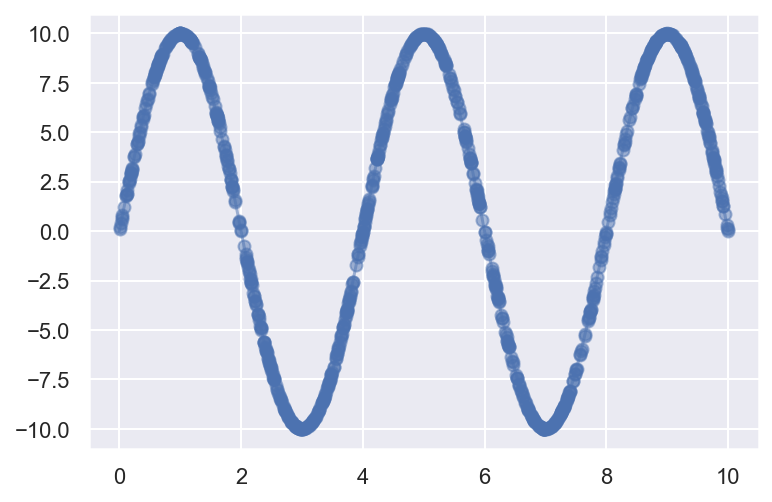

In [324]:
np.random.seed(0)

def true_f(x):
    return jnp.sin(x * jnp.pi * 0.5) * 10

n = 1000
x = jnp.array(np.sort(np.random.uniform(0, 10, n)))
f = true_f(x)
y = jnp.array(scipy.stats.bernoulli.rvs(jax.scipy.special.expit(f)))

plt.scatter(x, y, alpha=0.5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.yticks([0, 1]);

fig, ax = plt.subplots()
x_plot = np.linspace(0, 10, 100)
ax.plot(x_plot, true_f(x_plot), alpha=0.5)
ax.scatter(x, f, alpha=0.5)

In [325]:
# Set random seed for reproducibility.
rng_key = random.PRNGKey(0)

nuts = MCMC(NUTS(sparse_model, target_accept_prob=0.8, max_tree_depth=10),
            num_samples=500, num_warmup=500)
nuts.run(rng_key, x, y, M=25)

sample: 100%|██████████| 1000/1000 [05:42<00:00,  2.92it/s, 1023 steps of size 1.03e-03. acc. prob=0.89]


In [330]:
nuts_samples = nuts.get_samples()

n_samples = nuts_samples['kernel_var'].shape[0]
f_predict = np.zeros((n_samples, x.shape[0]))
p_predict = np.zeros((n_samples, x.shape[0]))
for i in tqdm(range(n_samples)):
    f_predict[i], p_predict[i] = gp_predict_sparse(Xnew=x, samples=nuts_samples, i=i)

100%|██████████| 500/500 [00:26<00:00, 18.83it/s]


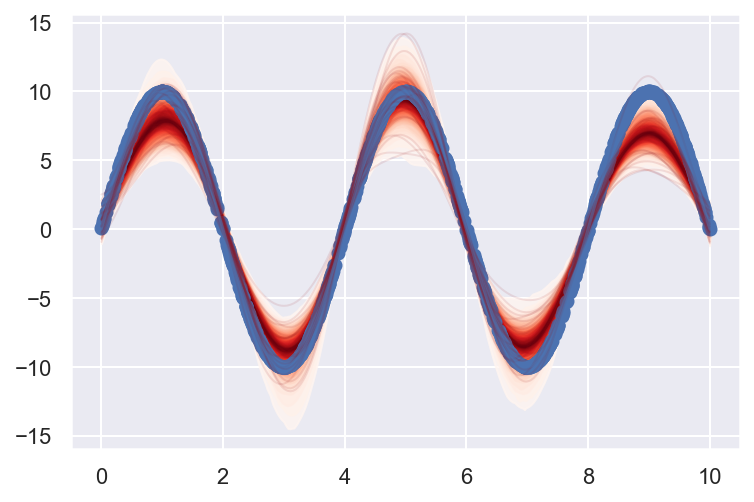

In [332]:
fig, ax = plt.subplots()
plot_gp_dist(ax, f_predict, x)
ax.scatter(x, f)
x_plot = np.linspace(0, 10, 100)
ax.plot(x_plot, true_f(x_plot), alpha=0.5);
# ax.set_ylim(-20, 20);